In [26]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
#from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
config = get_config()
print(config.data_path)
print(config.scoreNet_trained_path)
num_paths = 0
num_time_steps = config.ts_length
isUnitInterval = True
diff = 1
initial_state = 0.
rvs = None
H = 0.5
deltaT = config.deltaT
t0 = config.t0
t1 = config.t1
if "QuadSin" in config.data_path:
    fBiPot = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_space_scale=config.sin_space_scale, sin_coeff = config.sin_coeff, diff=diff, X0=initial_state)
elif "BiPot" in config.data_path:
    fBiPot = FractionalBiPotential(quartic_coeff=config.quartic_coeff, quad_coeff=config.quad_coeff, const = config.const, diff=diff, X0=initial_state)
if num_paths > 0:
    sim_data = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape((num_paths, num_time_steps+1))

    plt.hist(sim_data.flatten(), density=True, bins=150)
    print(max(np.abs(sim_data.flatten())))
    plt.show()
    plt.close()
diffs = []
paths = []
for k in range(num_paths):
    path = sim_data[k,:]
    if "QuadSin" in config.data_path:
        drifts = -2*config.quad_coeff * path[:-1] + config.sin_space_scale*config.sin_coeff*np.sin(config.sin_space_scale*path[:-1])
    elif "BiPot" in config.data_path:
        drifts = -(4*config.quartic_coeff * np.power(path[:-1],3) + config.quad_coeff*path[:-1] + config.const)
    plt.scatter(path[:-1], drifts, s=1, label="True")
    d = (np.diff(path)[np.abs(path[1:])<np.inf])
    if len(d) > 0:
        diffs.append(d)
    paths.append(path)
plt.show()
plt.close()
if num_paths > 0 and ("QuadSin" in config.data_path):
    cs, bins, _ = plt.hist(config.sin_space_scale*np.concatenate(diffs).flatten(), bins=100, density=True, label="Histogram")
    print(max(config.sin_space_scale*np.abs(np.concatenate(diffs).flatten())))
    plt.vlines(x=1., ymin=0., ymax=max(cs), color="orange", label="Frequency Limit")
    plt.legend()
    plt.show()
    plt.close()


/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy
/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_TSM_2LFac_fQuadSinHF_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_LSTM_H20_Nly1_tl110


In [28]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))
def plot_drift_estimator(mean, stds, numpy_Xs, type, true_drift, ts_type,ts_type_num, Nepoch,toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")

    #ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Estimated Drift")
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"RMSE {round(rmse,3)} for LSTM Score Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_LSTM_{Nepoch}Nep_{config.deltaT:.3e}dT_{config.loss_factor}LFac.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [29]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import ConditionalLSTMTSScoreMatching

config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 300
ts_type_num = 2
toSave = False
# Fix the number of training epochs and training loss objective loss
if "PM" in config.scoreNet_trained_path:
    PM = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters).to(device)
else:
    PM = ConditionalLSTMTSScoreMatching(*config.model_parameters).to(device)
PM.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))

0.0
Using CPU



<All keys matched successfully>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.9657977373189848

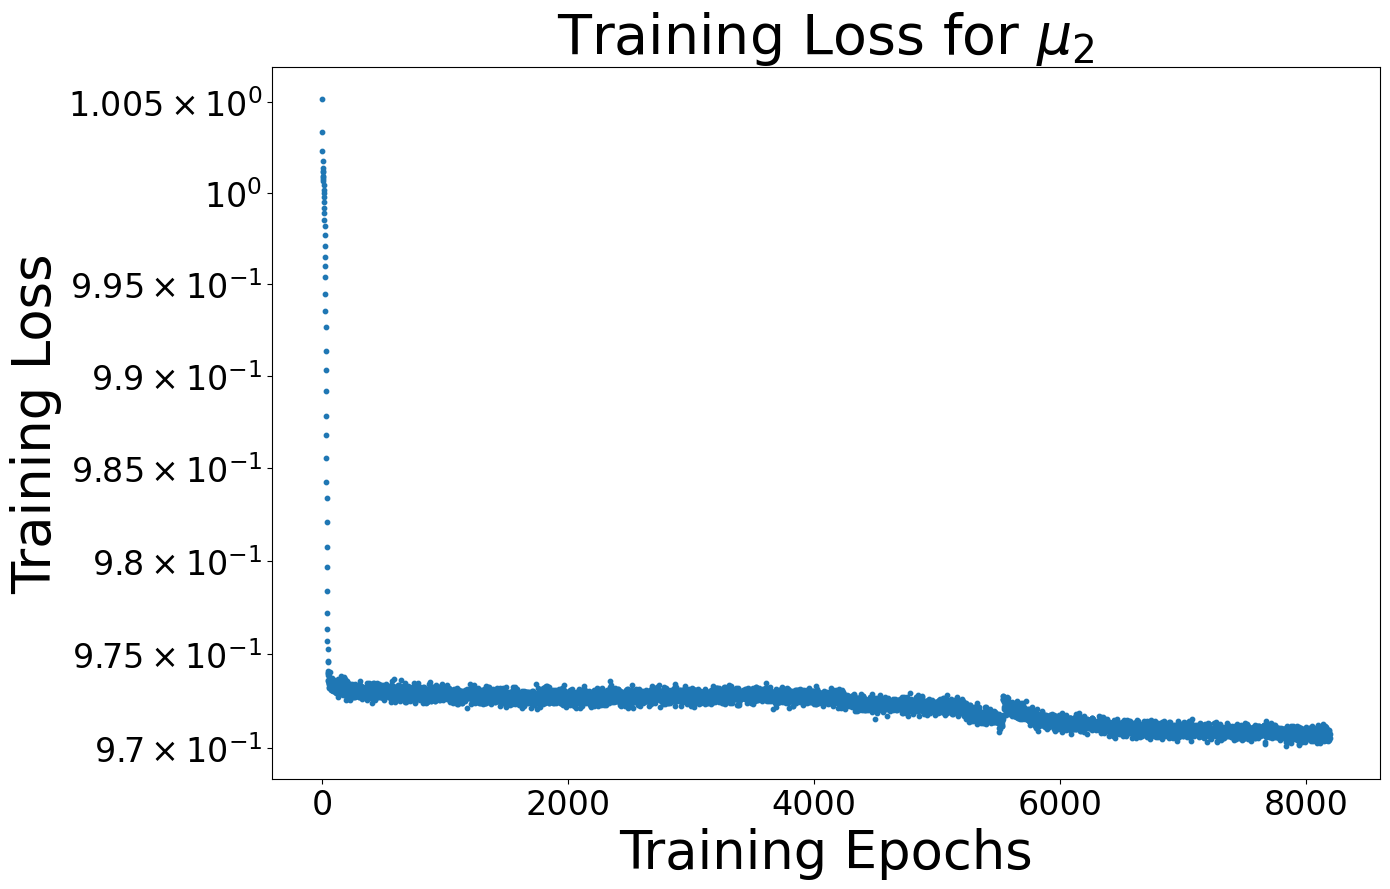

In [30]:
%load_ext autoreload
%autoreload 2
from matplotlib.ticker import LogLocator
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config
#from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config
gconfig = get_config()
with open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)[:8190]
start_idx = 2
fig, ax = plt.subplots(figsize=(14,9))
ax.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:], s=10)
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_ylabel("Training Loss", fontsize=38)
ax.set_title(r"Training Loss for $\mu_{2}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax.set_yscale("log")
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto', numticks=10))
plt.tight_layout()
#plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fQuadSinHF_LSTM_TrainLoss_{gconfig.deltaT:.3e}dT_{gconfig.loss_factor}LFac.png",  bbox_inches='tight')
losses[-1]/losses[start_idx]

<_io.BufferedReader name='/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/training_losses/trained_rec_ST_PM_TSM_2LFac_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_LSTM_H20_Nly1_tl110_loss'>


0.36517449694526244

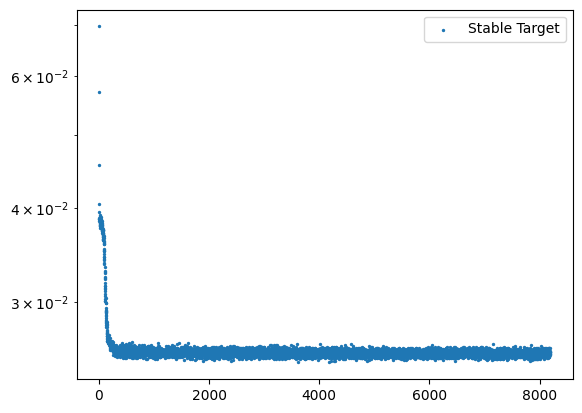

In [31]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_config
gconfig2 = get_config()
with open(gconfig2.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        print(f)
        losses2 = np.array(pickle.load(f))[:losses.shape[0]]
plt.scatter(np.arange(start_idx, losses2.shape[0]), losses2[start_idx:],s=2, label="Stable Target")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses2[-1]/losses2[start_idx]

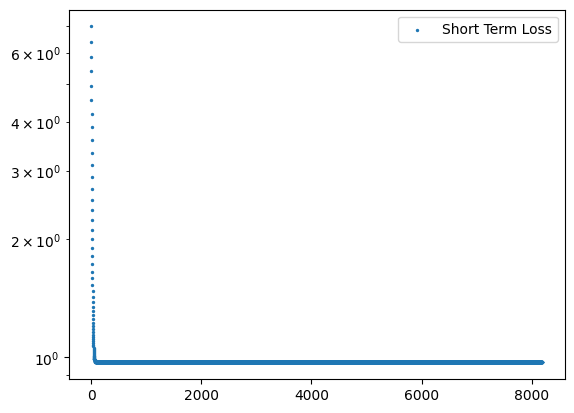

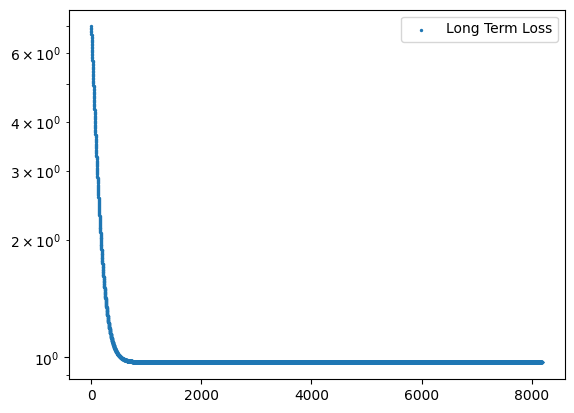

In [32]:
start_idx = 00
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_60Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


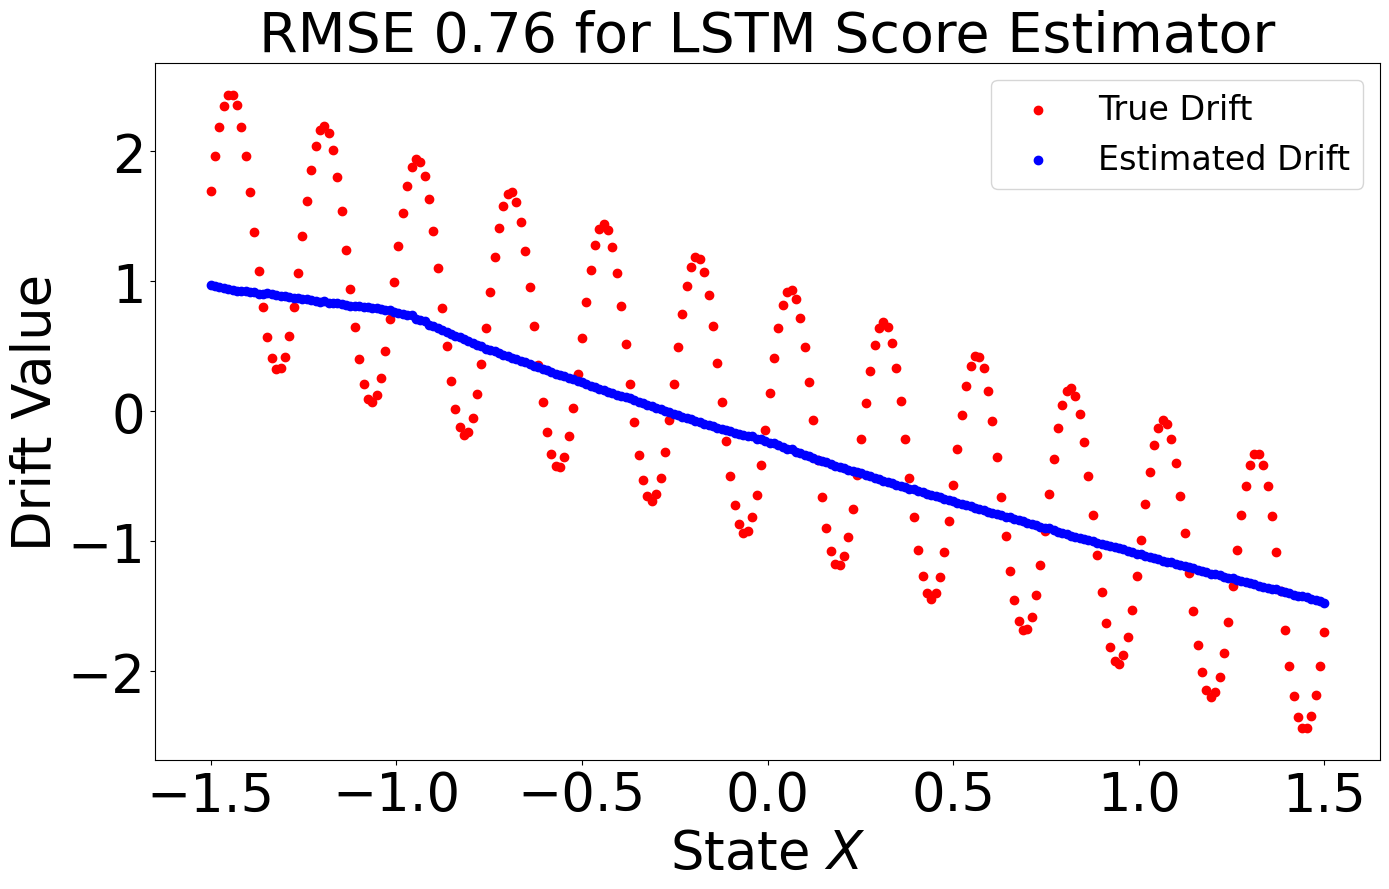

Epoch 60 done with Best RMSE 0.7602947950363159




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_100Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


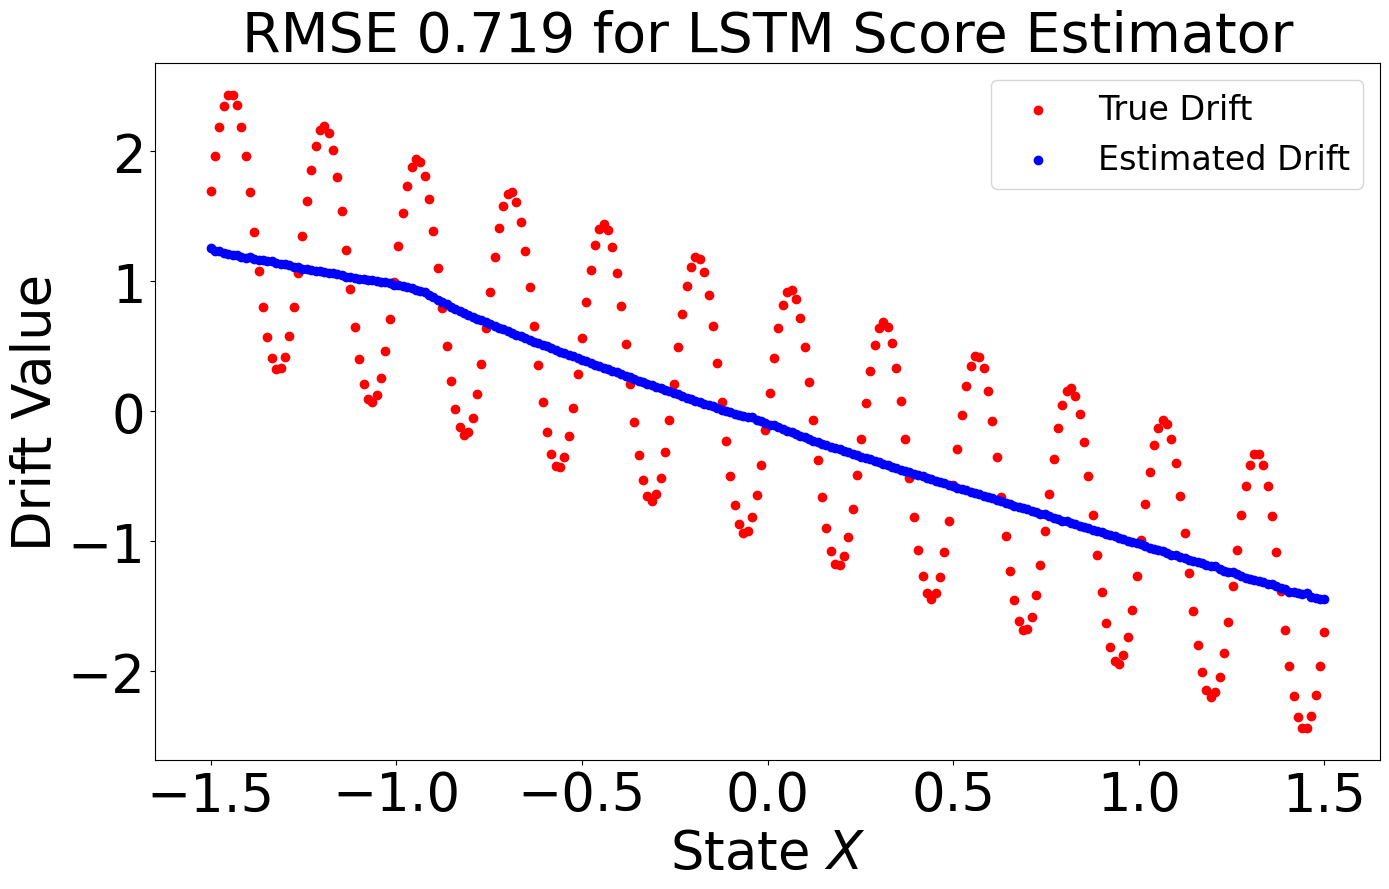

Epoch 100 done with Best RMSE 0.719253420829773




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_150Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


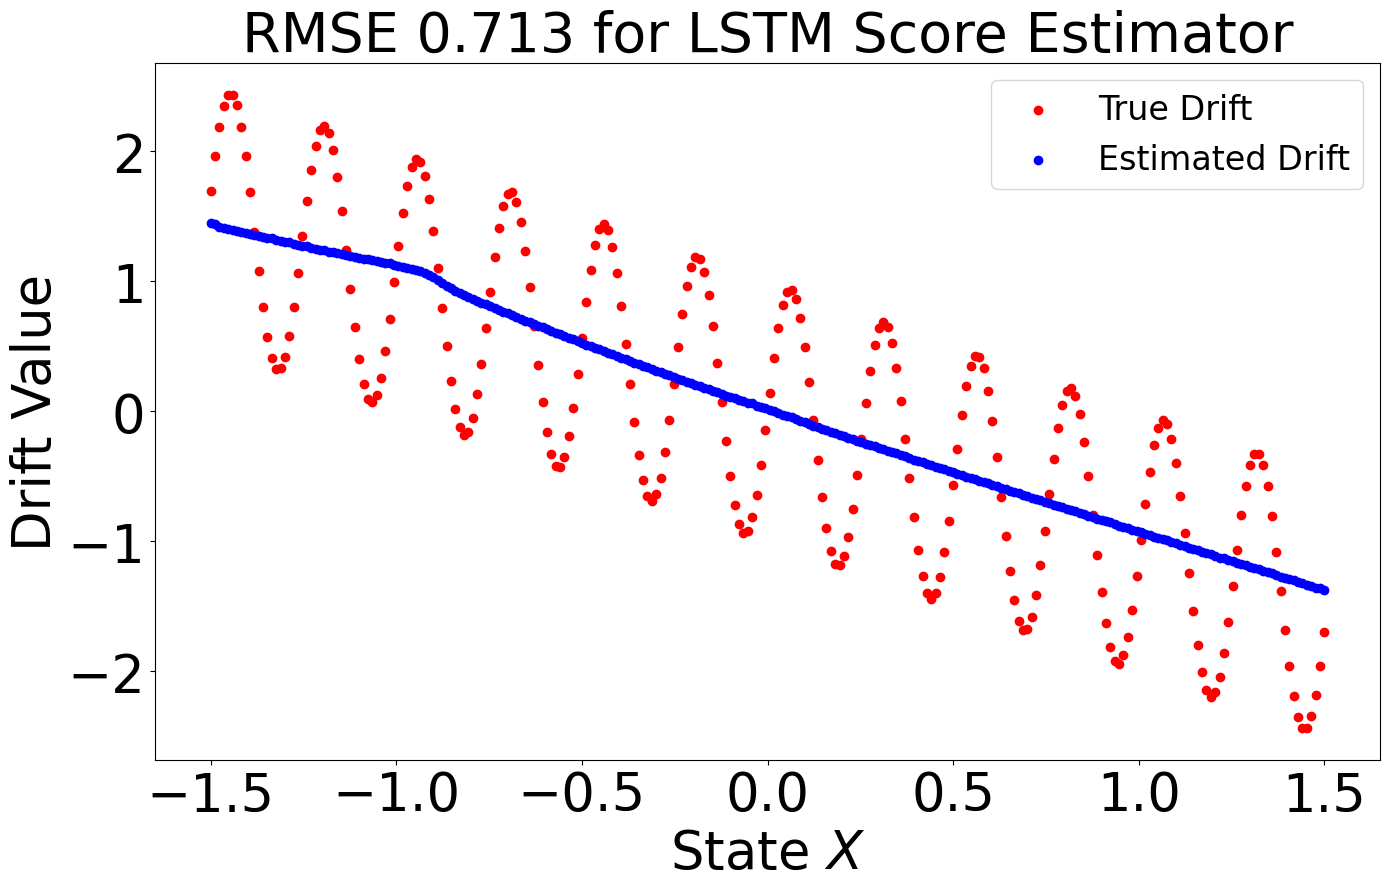

Epoch 150 done with Best RMSE 0.7129389643669128




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_300Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0
Epoch 300 done with Best RMSE 0.7129389643669128




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_960Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0
Epoch 960 done with Best RMSE 0.7129389643669128




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_1440Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0
Epoch 1440 done with Best RMSE 0.7129389643669128




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_1920Nep_00t0_3906e-03dT_05a

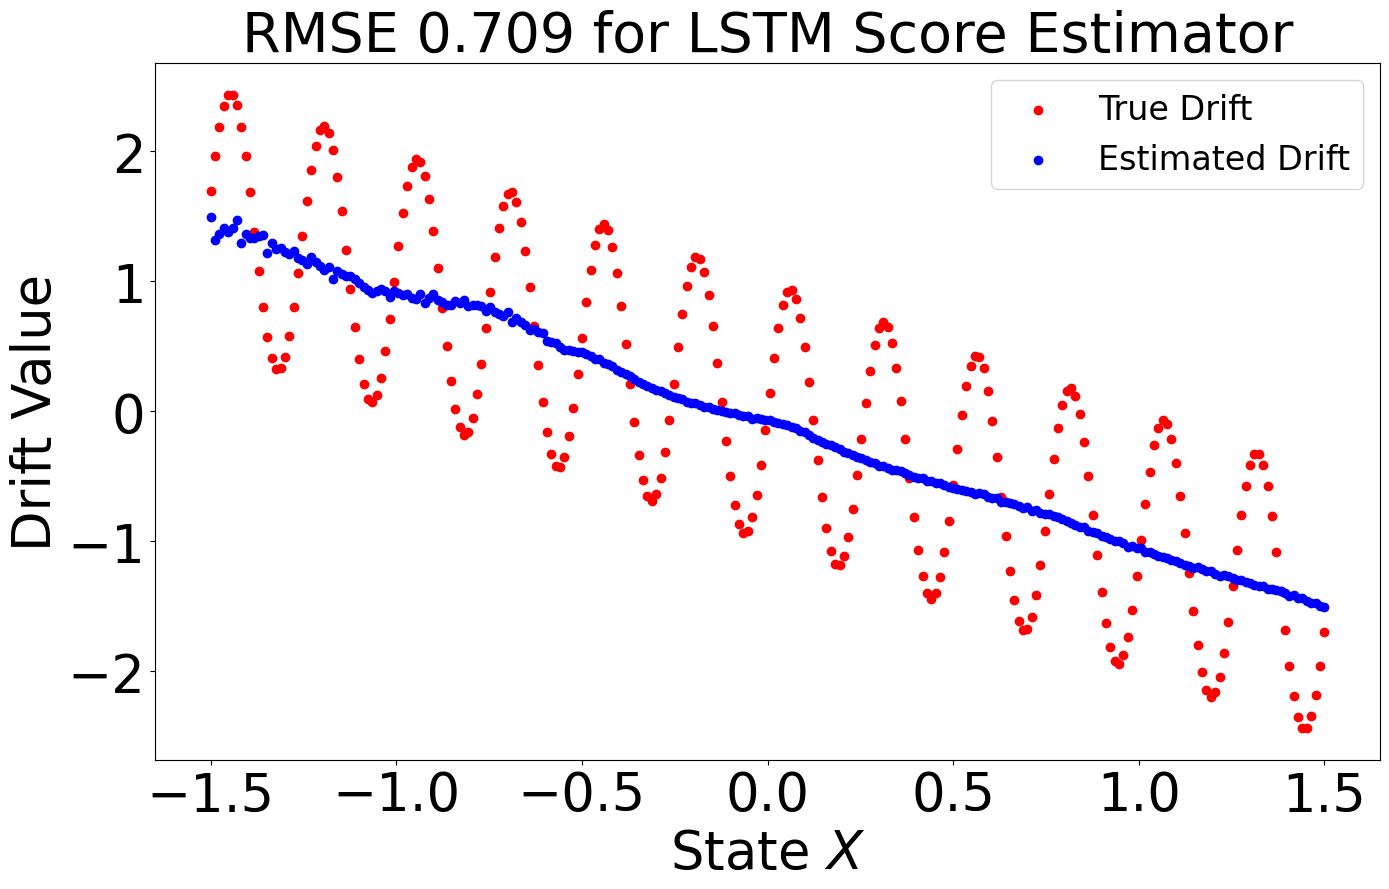

Epoch 2920 done with Best RMSE 0.7093701362609863




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_6920Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


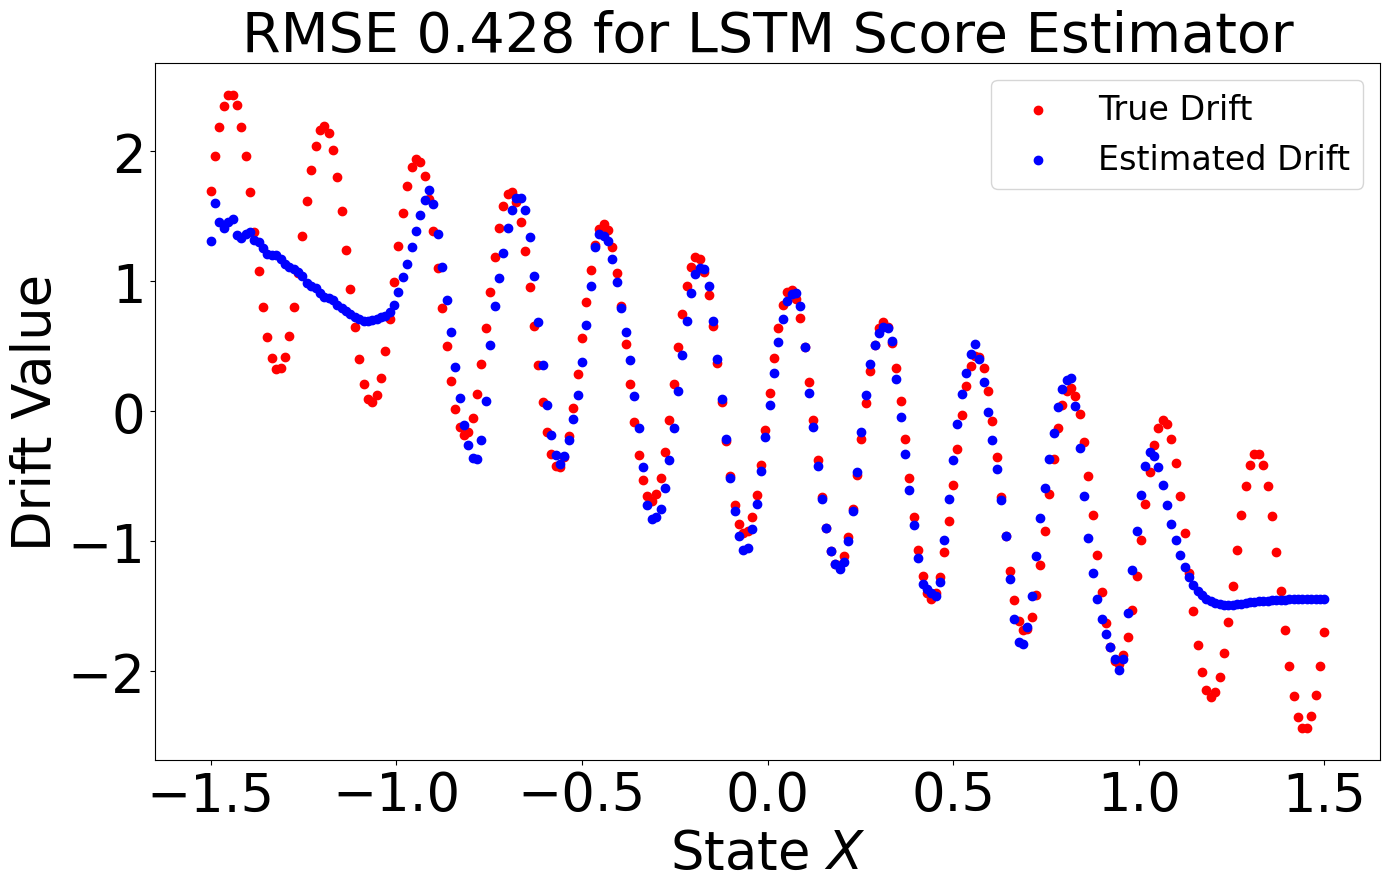

Epoch 6920 done with Best RMSE 0.42819032073020935




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_7190Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


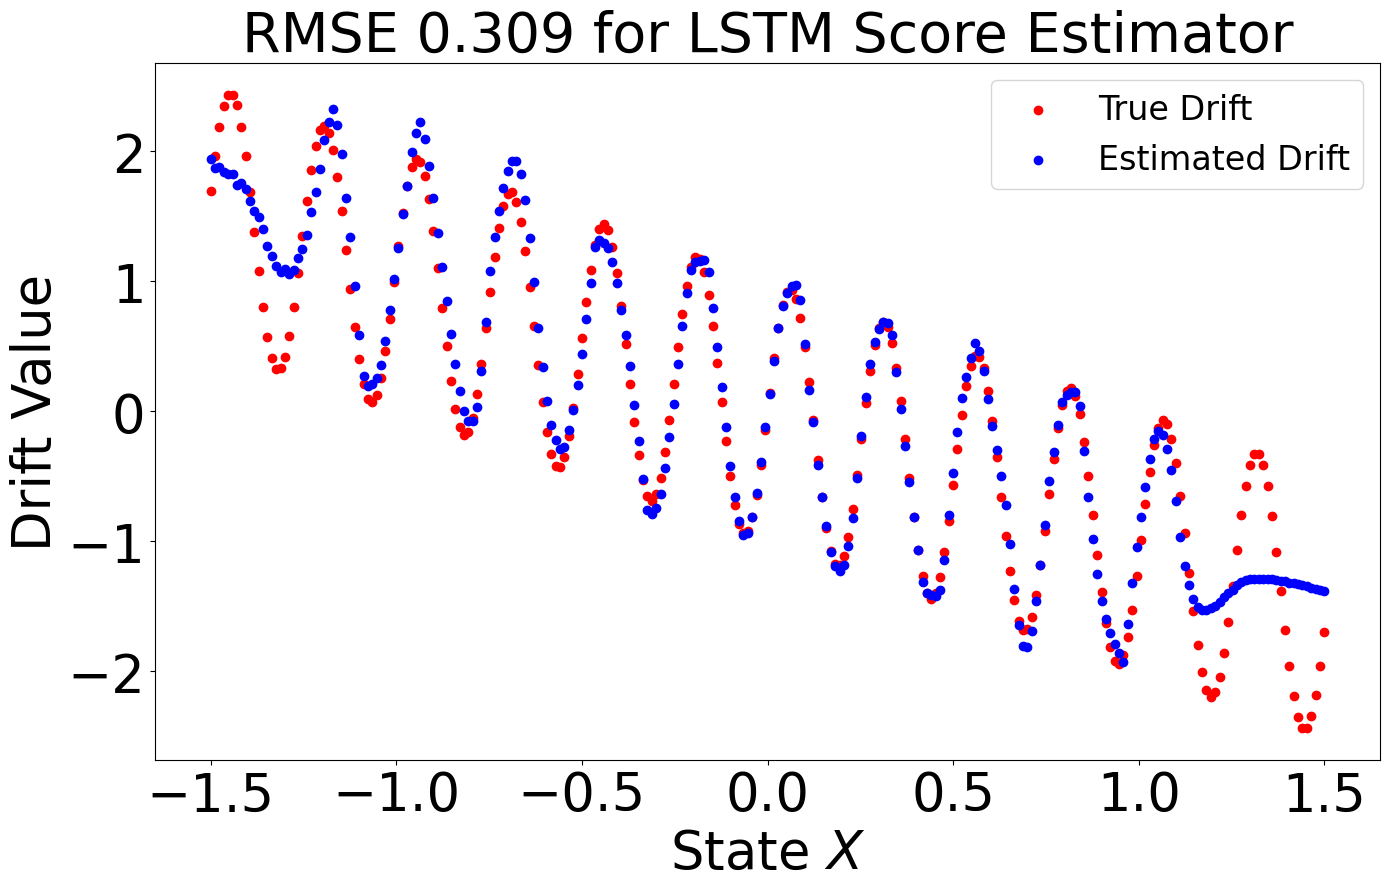

Epoch 7190 done with Best RMSE 0.30920132994651794




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_8190Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0


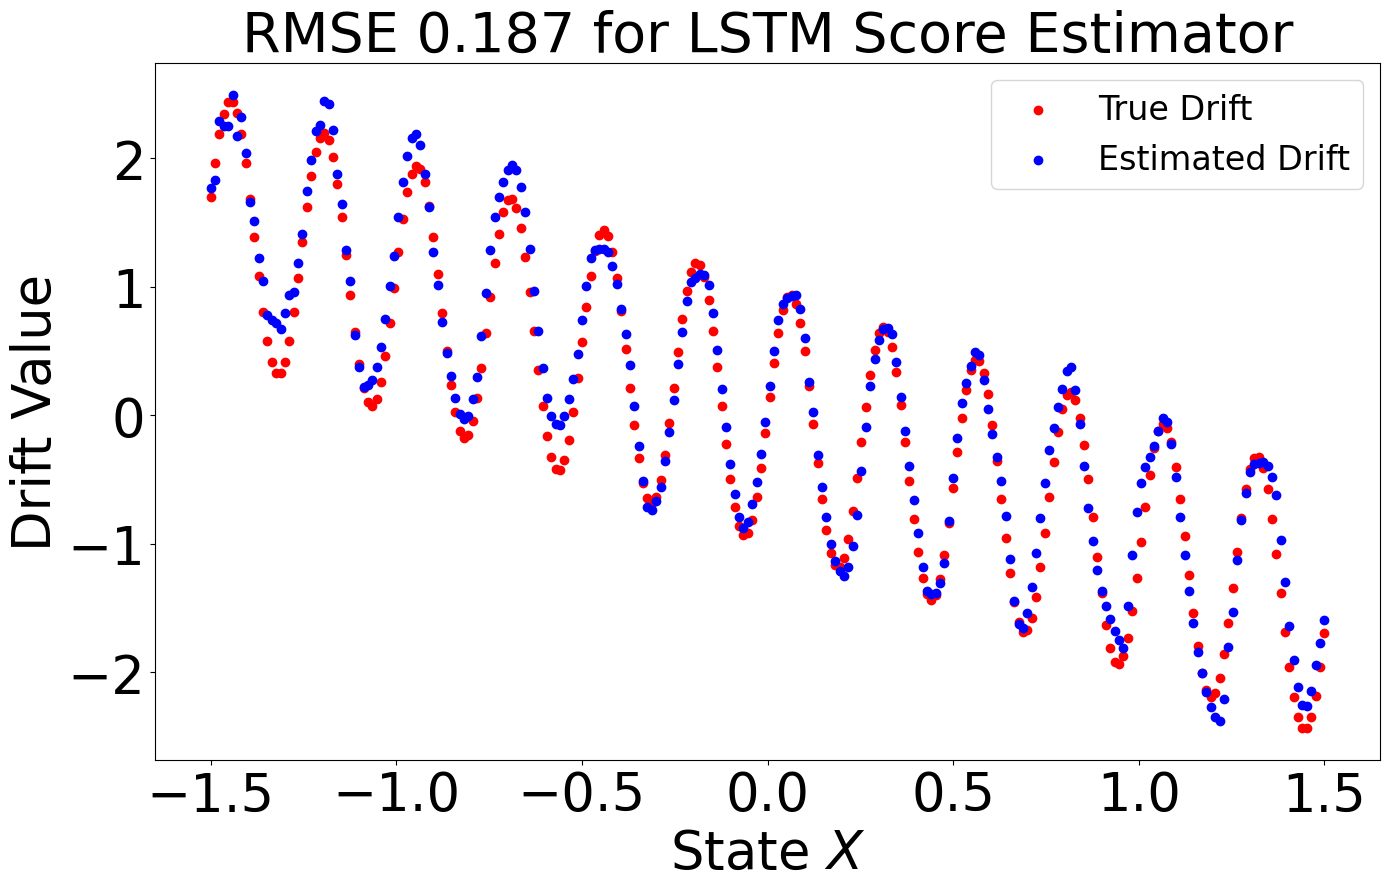

Epoch 8190 done with Best RMSE 0.1874781847000122




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_9700Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
PM fQuadSinHF 10000 torch.Size([256, 1, 100])
0.5 0.04 25.0
Epoch 9700 done with Best RMSE 0.1874781847000122




/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_12920Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_12920Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_muhats.npy'


In [33]:
best_rmse = np.inf
for Nepoch in config.max_epochs:
    try:
        Ndiff = config.max_diff_steps
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""

        if "fSin" in config.data_path:
            file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_LSTM_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
        elif "fQuadSinHF" in config.data_path:
            file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                            ".", "")
            print(file_path)
        elif "fBiPotSmall" in config.data_path:
            file_path = (
                    project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPotSmall_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
                ".", "")
        elif "fBiPot" in config.data_path:
            file_path = (
                        project_config.ROOT_DIR + f"experiments/results/TS{type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                    ".", "")
        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fSin" in config.data_path:
            Xs = torch.Tensor(np.linspace(-3,3,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type = "fSin"
        elif "fBiPotSmall" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPotSmall"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        if type == "":
            type="Standard"
        print(type, ts_type, Ndiff, muhats.shape)
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
            print(config.quad_coeff, config.sin_coeff, config.sin_space_scale)
        elif "fSin" in config.data_path:
            true_drifts = config.mean_rev*np.sin(1*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
            #true_drifts = true_drifts/(1.+config.deltaT*torch.abs(true_drifts))
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        stds = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts.numpy(), mu_hats).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=Xs.numpy(), type=type, toSave=toSave, true_drift=true_drifts.numpy(), ts_type=ts_type, ts_type_num=ts_type_num, Nepoch=Nepoch)
        print(f"Epoch {Nepoch} done with Best RMSE {best_rmse}\n\n\n\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(e)
        continue